# Podstawowa sieć neuronowa w PyTorch
Czas połączyć wszystkie elementy. W tej sekcji:
* stworzymy wielowarstwowy model głębokiego uczenia
* wczytamy dane
* wytrenujemy i zweryfikujemy model<br>

Wprowadzimy też nowy krok:
* zapisywanie i wczytywanie wytrenowanego modelu

Naszym celem jest zbudowanie modelu, który potrafi sklasyfikować kwiat irysa na podstawie czterech cech. 

Jest to klasyfikacja wieloklasowa, w której każda próbka może należeć do JEDNEJ z 3 klas:

* <em>Iris setosa</em>,
* <em>Iris virginica</em>
* <em>Iris versicolor</em>).


Sieć będzie mieć 4 neurony wejściowe (wymiary kwiatu) i 3 neurony wyjściowe (wyniki). 

Funkcja straty porówna etykietę docelową (ground truth) z odpowiadającym jej wynikiem na wyjściu.


<div class="alert alert-info">

**UWAGA:**  
Przy klasyfikacjach wieloklasowych zwykle przekształcamy wektor etykiet w macierz zakodowaną one-hot.  

Jeśli 5 etykiet wygląda tak:

```python
tensor([0, 2, 1, 0, 1])
````

wówczas zakodujemy je następująco:

```python
tensor([[1, 0, 0], # 0
        [0, 0, 1], # 2
        [0, 1, 0], # 1
        [1, 0, 0], # 0
        [0, 1, 0]])# 1
```

To łatwo uzyskać funkcją [`torch.nn.functional.one_hot()`](https://pytorch.org/docs/stable/nn.html#one-hot).

In [1]:
import torch
import torch.nn as nn

In [2]:
etykiety = torch.tensor([0, 2, 1, 0, 1])

torch.nn.functional.one_hot(etykiety)

tensor([[1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [1, 0, 0],
        [0, 1, 0]])

W naszym przypadku funkcja straty [`torch.nn.CrossEntropyLoss()`](https://pytorch.org/docs/stable/nn.html#crossentropyloss) zrobi to za nas.

</div>

## Wykonaj standardowe importy


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Zdefiniuj klasę modelu
W tym ćwiczeniu korzystamy ze zbioru danych irysów. Ponieważ pojedyncza prosta nie potrafi rozdzielić trzech gatunków, powinniśmy uwzględnić przynajmniej jedną warstwę ukrytą.

W metodzie forward użyjemy funkcji <a href='https://en.wikipedia.org/wiki/Rectifier_(neural_networks)'>Rectified Linear Unit</a> (ReLU)<br>
$\quad f(x)=\max(0,x)$<br>
jako funkcji aktywacji. Jest ona dostępna jako pełny moduł <a href='https://pytorch.org/docs/stable/nn.html#relu'><strong><tt>torch.nn.ReLU</tt></strong></a> lub w postaci wywołania funkcyjnego <a href='https://pytorch.org/docs/stable/nn.html#id27'><strong><tt>torch.nn.functional.relu</tt></strong></a>.


In [30]:
class Model(nn.Module):
    def __init__(self, in_features=4, h1=8, h2=9, out_features=3):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)    # warstwa wejściowa
        self.fc2 = nn.Linear(h1, h2)            # warstwa ukryta
        self.out = nn.Linear(h2, out_features)  # warstwa wyjściowa
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

In [31]:
# Utwórz instancję klasy Model z domyślnymi parametrami:
torch.manual_seed(32)
model = Model()

## Wczytaj zbiór danych irysów


In [32]:
df = pd.read_csv('../Data/iris.csv')
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


## Wykreśl zbiór danych
Zbiór irysów zawiera 4 cechy. Aby zorientować się, jak się ze sobą korelują, narysujemy cztery ich wzajemne zależności.<br>
Skorzystamy z indeksów kolumn, aby pobrać ich nazwy parami: <tt>plots = [(0,1),(2,3),(0,2),(1,3)]</tt>.<br>
Para <tt>(0,1)</tt> odpowiada ustawieniu „sepal length (cm)” jako <tt>x</tt> oraz „sepal width (cm)” jako <tt>y</tt>.


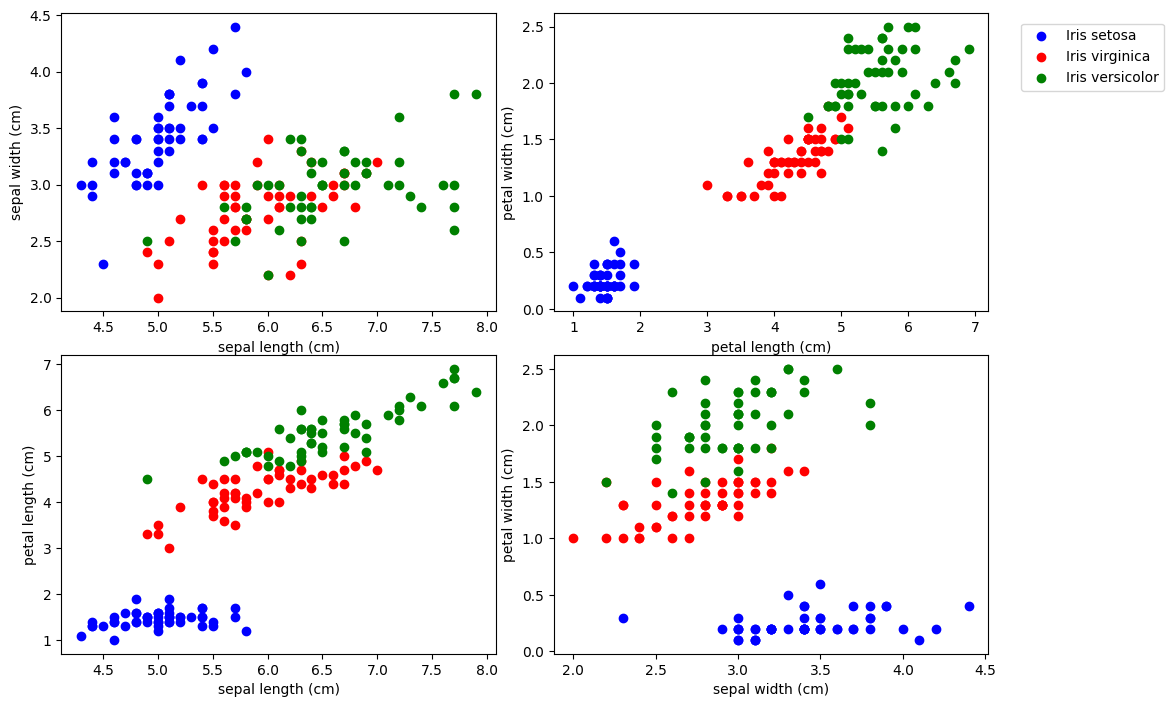

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['b', 'r', 'g']
labels = ['Iris setosa','Iris virginica','Iris versicolor']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = df.columns[plots[i][0]]
        y = df.columns[plots[i][1]]
        ax.scatter(df[df['target']==j][x], df[df['target']==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)

fig.legend(labels=labels, loc=3, bbox_to_anchor=(1,0.85))
plt.show()

## Przeprowadź Train/Test/Split


In [34]:
X = df.drop('target',axis=1).values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=33)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
# y_train = F.one_hot(torch.LongTensor(y_train))  # niepotrzebne przy Cross Entropy Loss
# y_test = F.one_hot(torch.LongTensor(y_test))
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

## Przygotuj DataLoader
W tej analizie nie musimy tworzyć obiektu Dataset, ale warto skorzystać z narzędzia DataLoader PyTorcha. Mimo że nasz zbiór jest niewielki (120 próbek treningowych), załadujemy go do modelu w dwóch partiach. Ta technika okazuje się niezwykle pomocna przy dużych zbiorach danych.

Zwróć uwagę, że scikit-learn potasował pierwotny zbiór jeszcze przed przygotowaniem zestawów treningowego i testowego. Mimo to warto skorzystać z opcji shuffle w DataLoaderze, jeśli będziemy wykonywać wiele przejść po zbiorze.


In [35]:
trainloader = DataLoader(X_train, batch_size=60, shuffle=True)

testloader = DataLoader(X_test, batch_size=60, shuffle=False)

## Zdefiniuj funkcję straty i optymalizator
Tak jak wcześniej, użyjemy <a href='https://en.wikipedia.org/wiki/Cross_entropy'>entropii krzyżowej</a> z funkcją <a href='https://pytorch.org/docs/stable/nn.html#crossentropyloss'><strong><tt>torch.nn.CrossEntropyLoss()</tt></strong></a>.<br>
Jako optymalizatora użyjemy odmiany stochastycznego spadku gradientowego o nazwie <a href='https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam'>Adam</a> (skrót od Adaptive Moment Estimation), zaimplementowanej w <a href='https://pytorch.org/docs/stable/optim.html#torch.optim.Adam'><strong><tt>torch.optim.Adam()</tt></strong></a>.


In [36]:
# DO POWTÓRZENIA
torch.manual_seed(4)
model = Model()

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # 0.01 to dobry wybór

## Wytrenuj model


In [38]:
epochs = 100
losses = []

for i in range(epochs):
    i+=1

    # wykonaj forward i pobierz predykcję
    y_pred = model.forward(X_train)

    # oblicz stratę/błąd
    loss = criterion(y_pred, y_train)
    losses.append(loss)
    
    # sprytny trik, żeby oszczędzić miejsce na ekranie:
    if i%10 == 1:
        print(f'epoch: {i:2}  loss: {loss.item():10.8f}')

    # PROPAGACJA WSTECZ
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch:  1  loss: 1.09568226
epoch: 11  loss: 0.98190629
epoch: 21  loss: 0.75652379
epoch: 31  loss: 0.49447367
epoch: 41  loss: 0.34981728
epoch: 51  loss: 0.22807977
epoch: 61  loss: 0.13547553
epoch: 71  loss: 0.09162236
epoch: 81  loss: 0.07378434
epoch: 91  loss: 0.06546316


In [39]:
criterion(y_pred, y_train)

tensor(0.0612, grad_fn=<NllLossBackward0>)

In [40]:
losses[0].detach().numpy()

array(1.0956823, dtype=float32)

## Wykres funkcji straty


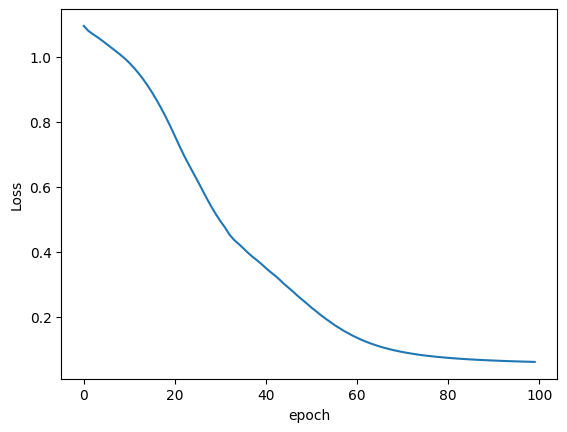

In [41]:
plt.plot(range(epochs), [loss.detach().numpy() for loss in losses])
plt.ylabel('Loss')
plt.xlabel('epoch');

## Zweryfikuj model
Teraz przepuścimy zbiór testowy przez model, aby sprawdzić, czy obliczona strata przypomina tę z danych treningowych.


In [42]:
# ABY OCENIĆ CAŁY ZBIÓR TESTOWY
# menedżer kontekstu wyłącza propagację wsteczną
with torch.no_grad():
    y_eval = model.forward(X_test)
    loss = criterion(y_eval, y_test)
print(f'{loss:.8f}')  # 0.4-0.7

0.06247801


In [43]:
# Kody kolorów ANSI
RED = '\033[91m'
GREEN = '\033[92m'
RESET = '\033[0m'  # przywróć domyślny kolor


# ile kwiatków rozpoznaliśmy poprawnie?
correct = 0
with torch.no_grad():
    for i,data in enumerate(X_test):
        y_val = model.forward(data)

        # można też tak:
        y_val = model(data)

        pred_val = list(y_val).index(y_val.max())
        act_val = y_test[i].item()
        is_correct = act_val == pred_val
        color = GREEN if is_correct else RED
        values = ", ".join(f"{v:7.3f}" for v in y_val.tolist())
        print(f'{i+1:2}. [{values:25}] predicted: {pred_val} actual: {act_val} {color}{is_correct}{RESET}')
        if y_val.argmax().item() == y_test[i]:
            correct += 1

print(f'\n{correct} out of {len(y_test)} = {100*correct/len(y_test):.2f}% correct')
# w każdym wierszu najwyższa liczba to wybrana klasa.
# ten tensor powstaje dlatego, że stosujemy Cross Entropy Loss

 1. [ -0.336,   7.363,   1.378] predicted: 1 actual: 1 True
 2. [  0.277,   8.155,   0.427] predicted: 1 actual: 1 True
 3. [ 11.997,   6.184, -19.198] predicted: 0 actual: 0 True
 4. [ -2.019,   7.966,   4.244] predicted: 1 actual: 1 True
 5. [ -6.135,   7.952,  11.091] predicted: 2 actual: 2 True
 6. [-10.264,   8.310,  17.999] predicted: 2 actual: 2 True
 7. [ 12.054,   6.432, -19.291] predicted: 0 actual: 0 True
 8. [ 12.950,   6.482, -20.753] predicted: 0 actual: 0 True
 9. [ -5.773,   8.243,  10.508] predicted: 2 actual: 2 True
10. [ -7.887,   8.613,  14.073] predicted: 2 actual: 2 True
11. [ -8.706,   8.607,  15.433] predicted: 2 actual: 2 True
12. [ 11.635,   5.816, -18.621] predicted: 0 actual: 0 True
13. [ -8.101,   8.233,  14.388] predicted: 2 actual: 2 True
14. [ -2.080,   7.775,   4.318] predicted: 1 actual: 1 True
15. [ -6.083,   8.392,  11.058] predicted: 2 actual: 2 True
16. [  0.135,   7.866,   0.641] predicted: 1 actual: 1 True
17. [ -4.088,   7.722,   7.664] predicte

Widzimy, że próbka numer 17 została błędnie sklasyfikowana.


In [44]:
y_val.argmax().item() == y_test[i].item()


True

## Zapisz wytrenowany model do pliku

W tej chwili obiekt `model` został wytrenowany i zweryfikowany — irysy klasyfikuje poprawnie w ~97% przypadków.  
Zapiszmy go na dysk.

Użyjemy narzędzi [`torch.save()`](https://pytorch.org/docs/stable/torch.html#torch.save) oraz [`torch.load()`](https://pytorch.org/docs/stable/torch.html#torch.load).

Istnieją dwie podstawowe metody zapisu modelu:

---

### 1. Zapis/Wczytanie `state_dict` (zalecane)

Ta metoda zapisuje i wczytuje **wyuczone parametry modelu**, ale nie samą klasę.

**Zapis:**
```python
torch.save(model.state_dict(), PATH)
````

**Odczyt:**

```python
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()
```

---

### 2. Zapis/Wczytanie całego modelu (pickle)

Ta metoda zapisuje cały obiekt modelu, łącznie z klasą i parametrami.
Jeśli chcesz wczytać go w innym notatniku, upewnij się, że wszystkie potrzebne definicje są dostępne.

**Zapis:**

```python
torch.save(model, PATH)
```

**Odczyt:**

```python
model = torch.load(PATH)
model.eval()
```

---

### Uwaga

W obu przypadkach należy wywołać `model.eval()`, aby warstwy **dropout** i **batch normalization** przeszły w tryb ewaluacji przed inferencją.
W przeciwnym razie możesz uzyskać niespójne wyniki.

📖 Więcej informacji: [PyTorch – Saving and Loading Models](https://pytorch.org/tutorials/beginner/saving_loading_models.html)


### Zapisz model


In [49]:
torch.save(model.state_dict(), 'IrisDatasetModel.pt')

### Wczytaj nowy model
Załadujemy nowy obiekt modelu i przetestujemy go tak jak wcześniej, aby upewnić się, że wszystko działa.


In [50]:
new_model = Model()
new_model.load_state_dict(torch.load('IrisDatasetModel.pt'))
new_model.eval()

Model(
  (fc1): Linear(in_features=4, out_features=8, bias=True)
  (fc2): Linear(in_features=8, out_features=9, bias=True)
  (out): Linear(in_features=9, out_features=3, bias=True)
)

In [51]:
with torch.no_grad():
    y_val = new_model.forward(X_test)
    loss = criterion(y_val, y_test)
print(f'{loss:.8f}')

0.06247801


## Zastosuj model, aby sklasyfikować nowe, nieznane dane


In [52]:
mystery_iris = torch.tensor([5.6,3.7,2.2,0.5])

Zaznaczmy tego nowego irysa na żółto, aby zobaczyć, gdzie wypada względem pozostałych:


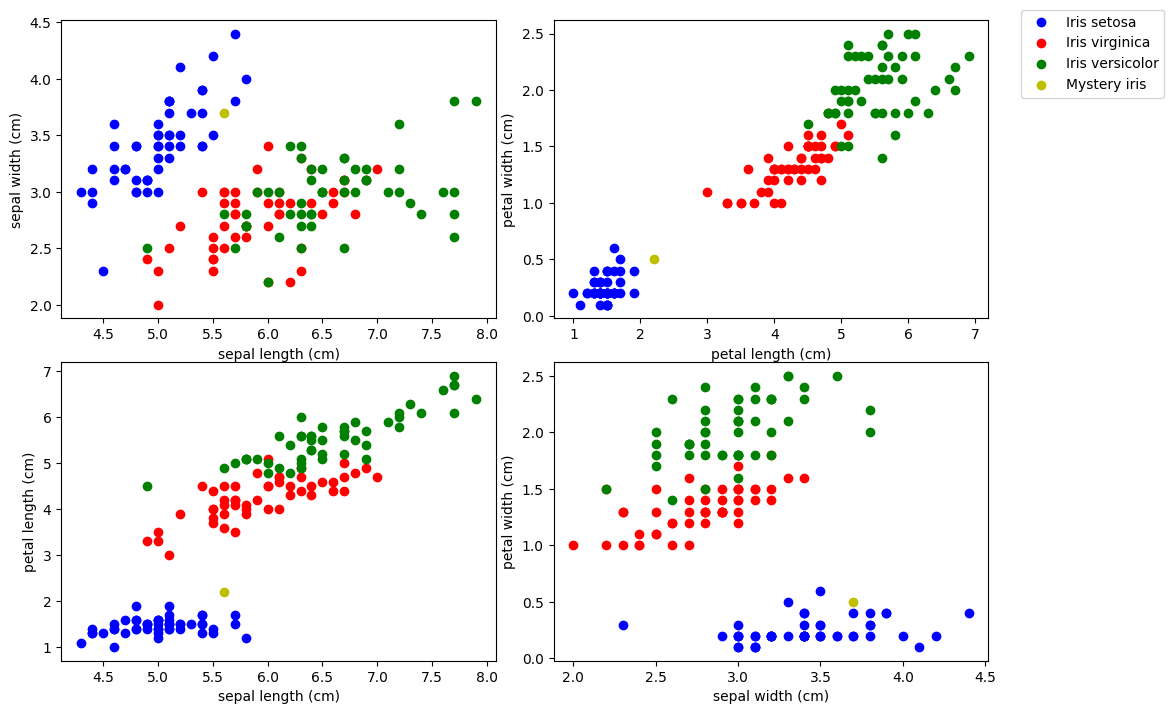

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
fig.tight_layout()

plots = [(0,1),(2,3),(0,2),(1,3)]
colors = ['b', 'r', 'g']
labels = ['Iris setosa','Iris virginica','Iris versicolor','Mystery iris']

for i, ax in enumerate(axes.flat):
    for j in range(3):
        x = df.columns[plots[i][0]]
        y = df.columns[plots[i][1]]
        ax.scatter(df[df['target']==j][x], df[df['target']==j][y], color=colors[j])
        ax.set(xlabel=x, ylabel=y)
        
    # Dodaj wykres naszego tajemniczego irysa:
    ax.scatter(mystery_iris[plots[i][0]],mystery_iris[plots[i][1]], color='y')
    
fig.legend(labels=labels, loc=3, bbox_to_anchor=(1.0,0.85))
plt.show()

Teraz przepuśćmy go przez model:


In [54]:
with torch.no_grad():
    print(new_model(mystery_iris))
    print()
    print(labels[new_model(mystery_iris).argmax()])

tensor([ 12.2112,   7.1279, -19.5248])

Iris setosa


## Świetna robota!
